In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as D
import torchvision.transforms as T
from torch.utils.data import DataLoader
import torchaudio

import numpy as np

from itertools import repeat

import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2
import sys
sys.path.append("../src")
from modules import WaveletNet, LazyWavelet, Lifting, Wavelet, FlattenLatents
from datasets import fetch_dataset

In [2]:
%matplotlib inline

# Generate toy dataset -- sample from bivariate normal distribution with mean 0.

In [3]:
x_sample = fetch_dataset('Sines')

x_sample.shape

torch.Size([256, 8192])

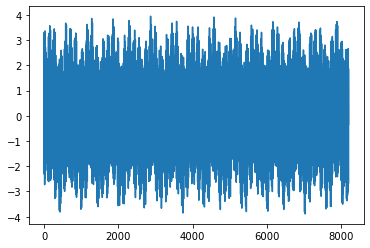

In [4]:
plt.plot(x_sample[0])

In [7]:
specgram = torchaudio.transforms.Spectrogram()

In [8]:
signal = x_sample[0].unsqueeze(0)
out = specgram(signal)

In [9]:
signal.shape

torch.Size([1, 8192])

In [10]:
out.shape

torch.Size([1, 201, 41])

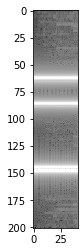

In [15]:
plt.imshow(out.log2()[0,:,:].numpy(), cmap='gray')

# Create normalizing flow model

In [44]:
lifting_dims = list(repeat([6,6], 8))
dims = list(repeat(lifting_dims, 8))
model = WaveletNet(dims, share_parameters=False)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

step = 0

In [25]:
dataloader = DataLoader(dataset=torch.cat(list(repeat(x_sample, 100))), batch_size=64)

# Visualize initial modeled frequency spectrum

In [55]:
x = model.sample(n_samples=1, sample_length=signal.shape[1])

signal = torch.tensor(x)
out = specgram(signal)
plt.imshow(out.log2()[0,:,:].numpy(), cmap='gray')

# Train model

In [54]:
for i, x in enumerate(dataloader):
    global step
    step += 1
    loss = - model.log_prob(x).mean()
    optimizer.zero_grad()
    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), 50)
    optimizer.step()
    if i % 20 == 0:
        with torch.no_grad():
            print(f"Step {i}. Loss: {loss}")

Step 0. Loss: 15718.0986328125
Step 20. Loss: 15348.5537109375
Step 40. Loss: 15315.072265625
Step 60. Loss: 15315.548828125
Step 80. Loss: 15306.88671875
Step 100. Loss: 15305.630859375
Step 120. Loss: 15303.7294921875
Step 140. Loss: 15301.515625
Step 160. Loss: 15299.3115234375
Step 180. Loss: 15296.90625
Step 200. Loss: 15294.1474609375
Step 220. Loss: 15290.8828125
Step 240. Loss: 15286.919921875
Step 260. Loss: 15282.048828125
Step 280. Loss: 15276.0546875
Step 300. Loss: 15268.7763671875
Step 320. Loss: 15260.2119140625
Step 340. Loss: 15250.625
Step 360. Loss: 15240.6181640625
Step 380. Loss: 15231.06640625


# Visualize the distribution that the model fits

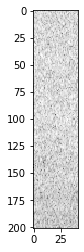

In [57]:
x = model.sample(n_samples=1, sample_length=signal.shape[1])

signal = torch.tensor(x)
out = specgram(signal)
plt.imshow(out.log2()[0,:,:].numpy(), cmap='gray')